<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: EOF analysis of monthly SST</h1>
<h3>Uses OpenDAP link to ERSST online at NOAA-PSD</h3>


<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Links to subsections
1. <a href="#opendap">OpenDAP: from a URL not a file. Examples of subsetting with xarray</a>
1. <a href="#eofs">Call the EOF package</a>
1. <a href="#eofpcplots">EOF x PC plots for a few top modes</a>
1. <a href="#orthogonality">Orthogonality check</a>


In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

dataset = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc')

In [2]:
tropicsdata = dataset.sel(lat =slice(30,-30)) # notice LAT ARRAY IS INVERTED!

tropics9899 = dataset.sel(time=slice(datetime(1998,1,1),datetime(1999,12,1)))\
                     .sel(lat =slice(30,-30)) # LAT ARRAY IS INVERTED!
tropics9899

<xarray.Dataset>
Dimensions:    (lat: 60, lon: 360, nbnds: 2, time: 24)
Coordinates:
  * lat        (lat) float32 29.5 28.5 27.5 26.5 25.5 24.5 23.5 22.5 21.5 ...
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * time       (time) datetime64[ns] 1998-01-01 1998-02-01 1998-03-01 ...
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    title:                           NOAA Optimum Interpolation (OI) SST V2
    Conventions:                     CF-1.0
    history:                         Wed Apr  6 13:47:45 2005: ncks -d time,0...
    comments:                        Data described in  Reynolds, R.W., N.A. ...
    platform:                        Model
    source:                          NCEP Climate Modeling Branch
    institution:                     National Centers for Environmental Predi...
    References:                      https://www.esrl.noaa.gov

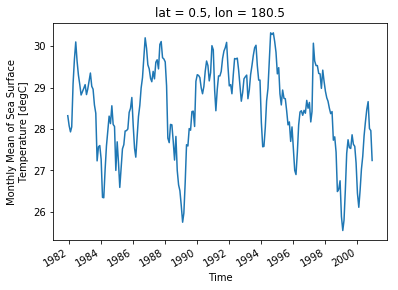

In [3]:
NINOdata = dataset.sel(time=slice(datetime(1980,1,1),datetime(2000,12,1)))\
                  .sel(lat=0, lon=180, method='nearest')

%matplotlib inline
NINOdata.sst.plot()

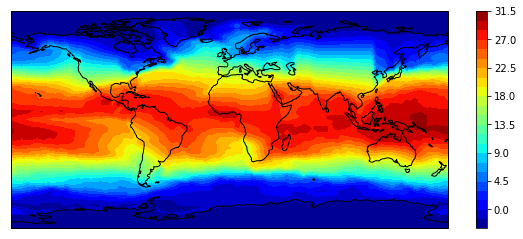

In [4]:
# CartoPy map plot at one time
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Sets the extent to cover the whole globe
# ax.set_global()

sst = ax.contourf(dataset.lon, dataset.lat, dataset.sel(time=datetime(1980,1,1), method='nearest').sst, 23,
                 transform=ccrs.PlateCarree(), 
                 cmap='jet')
ax.add_feature(cfeat.COASTLINE)
plt.colorbar(sst)

<a name="eofs"></a>
## Let's do an EOF analysis the easy way
With a package, from our field
https://openresearchsoftware.metajnl.com/articles/10.5334/jors.122/

In [5]:
from eofs.standard import Eof # import standard eofs from python eofs package, 
                              # to install eofs package use `conda install eofs` in environment you want to add it to
                              # for API see http://ajdawson.github.io/eofs/api/index.html for more information.

In [6]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights (area weighting of variance) is applied before the computation of EOFs.
# coslat = np.cos(np.deg2rad(tropiclat))
# wgts = np.sqrt(coslat)[:, np.newaxis]
# solver = Eof( tropics.data, wgts )

# Unweighted (just gridpoint variance)

solver = Eof( tropics9899.sst.data )

## Having done all the computations, just unpack and plot

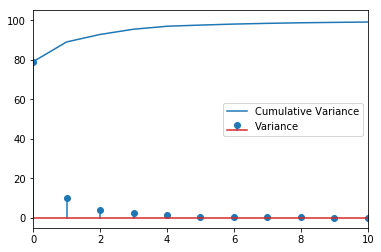

In [7]:
variance=solver.varianceFraction() # this is same as eigenvals/sum(eigenvals)

plt.stem(variance*100.0,label="Variance")
plt.plot(variance.cumsum()*100.0,label="Cumulative Variance")
plt.xlim(0,10,1)
plt.legend()

### Look at the EOF structures and PC time series

In [8]:
# Retrieve the EOFs and PCs
eofs = solver.eofs()
pcs = solver.pcs()

# Retrieve the correlation between the leading PC time series 
# and the input SST anomalies at each grid point.
eofsasCorr = solver.eofsAsCorrelation()

# Retrieve the EOF expressed as the covariance between the leading  PC time series 
# and the input SST anomalies at each grid point.
eofsasCov = solver.eofsAsCovariance()

## Is it a data reduction (compression) yet?

In [9]:
print(np.shape(eofs), np.shape(pcs))
print(np.shape(tropics9899.sst.data))

(24, 60, 360) (24, 24)
(24, 60, 360)


<a name="eofpcplots"></a>
## Let's look at the modes

In [10]:
def plot_map_ts(xydata,ts,lon,lat,time, label1, label2): 
    fig = plt.figure(figsize=(10, 4))

    ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
    cmap = ax.contourf(lon, lat, xydata, 23, 
                 transform=ccrs.PlateCarree(), 
                 cmap='seismic')
    plt.colorbar(cmap, orientation='horizontal')
    ax.add_feature(cfeat.COASTLINE)
    ax.set_title(label1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(time, ts) 
    ax2.set_title(label2)

0.0067299674
0.00606851
0.006776429
0.0061687212


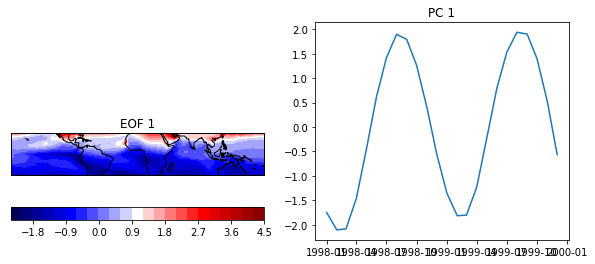

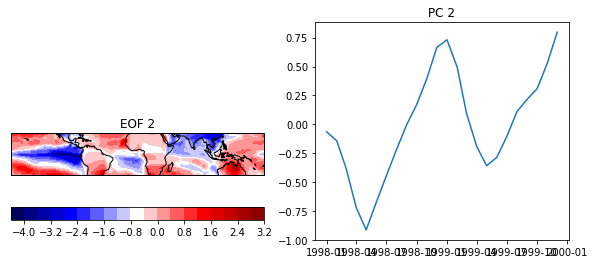

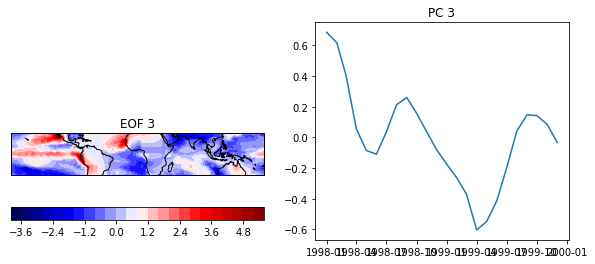

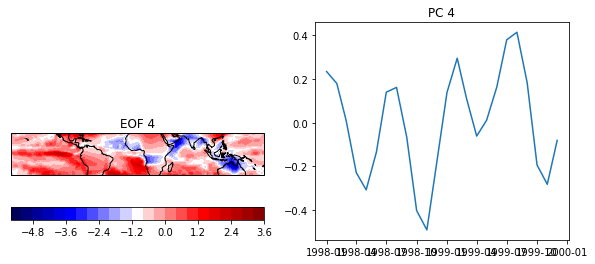

In [11]:
# Put the magnitude info into the PC for clarity of plot axis reading vs. colorbar reading
for MODE in [0,1,2,3]:
    xystd = np.std(eofs[MODE,:,:].ravel())
    print(xystd)
    plot_map_ts(eofs[MODE,:,:]/xystd, pcs[:,MODE]*xystd,
                                 tropics9899.lon,
                                 tropics9899.lat,
                                 tropics9899.time, 
            'EOF '+str(MODE+1), 'PC '+str(MODE+1))

<a name="orthogonality"></a>
## Check orthogonality

In [12]:
# corrcoef -- hey why not zero?
np.corrcoef(eofs[0,:,:].ravel(), eofs[1,:,:].ravel())

array([[ 1.        , -0.07549177],
       [-0.07549177,  1.        ]])

In [13]:
# Ohhhh - because correlation subtracts the mean! 
# Really the EOFs are orthogonal as a VECTOR DOT PRODUCT, not ANOMALY PATTERN CORRELATION.
np.sum(eofs[0,:,:].ravel() * eofs[1,:,:].ravel())

0.0

In [14]:
# The PCs seem orthogonal even when means are removed
np.corrcoef(pcs[:,0], pcs[:,1])

array([[1.00000000e+00, 1.87961874e-08],
       [1.87961874e-08, 1.00000000e+00]])

## Truncated reconstructions: animated
Grab some cells from Unidata's workshop notebook on making animations.
You have to make one image, then animate the others

In [15]:
import matplotlib.animation as manimation
plt.rcParams['animation.html'] = 'jshtml'

In [16]:
def recon(TRUNC, time): 
    data = eofs[0,:,:] * pcs[time,0] # Always include the first one
    for i in range(1,TRUNC):
        data += eofs[i,:,:] * pcs[time,i]
    return(data)

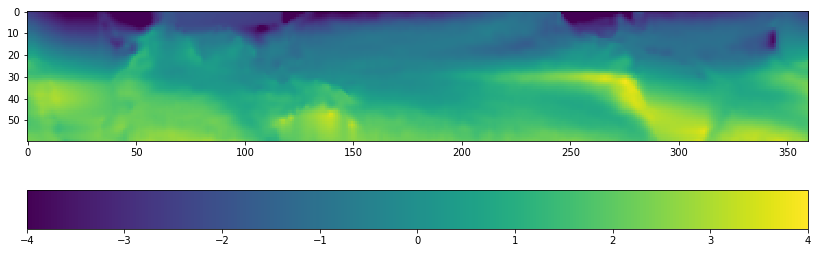

In [17]:
# Make one figure to set the pattern

fig, ax = plt.subplots(figsize=(14,6))

im = ax.imshow(recon(1,0), animated=True, vmin=-4, vmax=4)
plt.colorbar(im, orientation='horizontal')

In [24]:
TRUNC = 5 ## Reconstruction truncation level (how many modes)

artists = []
for it in range(0, len(pcs[:,0])):   
    im = ax.imshow(recon(TRUNC,it), vmin=-4, vmax=4)
    ax.set_title('Truncation '+str(TRUNC)+' modes')
    artists.append([im]) # NOTE THE LIST

manimation.ArtistAnimation(fig, artists, interval=500)

In [23]:
TRUNC = 1 ## Reconstruction truncation level (how many modes)

artists = []
for it in range(0, len(pcs[:,0])):   
    im = ax.imshow(recon(TRUNC,it), vmin=-4, vmax=4)
    ax.set_title('Truncation '+str(TRUNC)+' modes')
    artists.append([im]) # NOTE THE LIST

manimation.ArtistAnimation(fig, artists, interval=500)

## Now we could do EOFs for ANY function of time and (perhaps 2D) space! 
Like a video... http://nbviewer.jupyter.org/github/MPOcanes/MPO624-2018/blob/master/assignments/module3-empiricaldecomp/EOF_of_video.ipynb